### Load Packages and Data

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import shap


# import seaborn as sns
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score, KFold


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [3]:
housing.shape

(2558, 65)

<IPython.core.display.Javascript object>

In [4]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

# The below average sale by neigborhood is to comfirm later the encoding worked

In [5]:
# Calculate the average sale price for each neighborhood
average_sale_price = housing.groupby("Neighborhood")["SalePrice"].mean()

# Display the average sale price
print(average_sale_price)

Neighborhood
Blmngtn    196237.173913
Blueste    143590.000000
BrDale     106094.827586
BrkSide    125992.475728
ClearCr    215997.435897
CollgCr    198103.720339
Crawfor    202027.956522
Edwards    132003.993865
Gilbert    189401.965035
Greens     193531.250000
IDOTRR     109743.000000
MeadowV     96836.470588
Mitchel    163389.029126
NAmes      144960.639706
NPkVill    140743.181818
NWAmes     190329.715447
NoRidge    326114.298507
NridgHt    313662.495868
OldTown    126476.975962
SWISU      132896.048780
Sawyer     137402.215827
SawyerW    189152.017857
Somerst    228761.853147
StoneBr    305307.930233
Timber     243461.807692
Veenker    251263.043478
Name: SalePrice, dtype: float64


<IPython.core.display.Javascript object>

In [6]:
housing.Neighborhood.unique()

array(['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 'Blmngtn',
       'Mitchel', 'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 'MeadowV',
       'BrDale', 'Gilbert', 'Timber', 'Somerst', 'BrkSide', 'NoRidge',
       'Sawyer', 'Crawfor', 'Greens', 'ClearCr', 'StoneBr', 'Veenker',
       'NPkVill', 'Blueste'], dtype=object)

<IPython.core.display.Javascript object>

In [7]:
# # define the mapping for the Neighborhood feature

# Neighborhood_mapping = {
#     "SWISU": 0,
#     "Edwards": 1,
#     "IDOTRR": 2,
#     "OldTown": 3,
#     "NWAmes": 4,
#     "Blmngtn": 5,
#     "Mitchel": 6,
#     "NridgHt": 7,
#     "NAmes": 8,
#     "CollgCr": 9,
#     "SawyerW": 10,
#     "MeadowV": 11,
#     "BrDale": 12,
#     "Gilbert": 13,
#     "Timber": 14,
#     "Somerst": 15,
#     "BrkSide": 16,
#     "NoRidge": 17,
#     "Sawyer": 18,
#     "Crawfor": 19,
#     "Greens": 20,
#     "ClearCr": 21,
#     "StoneBr": 22,
#     "Veenker": 23,
#     "NPkVill": 24,
#     "Blueste": 25,
# }

<IPython.core.display.Javascript object>

### Ordinal encoding data

# This code encodes the 'Neighborhood' column of a housing dataset using a custom mapping, and encodes other categorical features using the OrdinalEncoder without specifying their categories.

In [8]:

# Getting a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# Removing the 'Neighborhood' column from cat_features since this will be dealt with in a different way
cat_features.remove('Neighborhood')


# Neighborhood mapping dictionary
Neighborhood_mapping = {
    "SWISU": 0,
    "Edwards": 1,
    "IDOTRR": 2,
    "OldTown": 3,
    "NWAmes": 4,
    "Blmngtn": 5,
    "Mitchel": 6,
    "NridgHt": 7,
    "NAmes": 8,
    "CollgCr": 9,
    "SawyerW": 10,
    "MeadowV": 11,
    "BrDale": 12,
    "Gilbert": 13,
    "Timber": 14,
    "Somerst": 15,
    "BrkSide": 16,
    "NoRidge": 17,
    "Sawyer": 18,
    "Crawfor": 19,
    "Greens": 20,
    "ClearCr": 21,
    "StoneBr": 22,
    "Veenker": 23,
    "NPkVill": 24,
    "Blueste": 25,
}

# Creating a list of neighborhoods sorted by their values in the dictionary
sorted_neighborhoods = sorted(Neighborhood_mapping, key=Neighborhood_mapping.get)

# Creating an instance of the OrdinalEncoder class with the custom categories for the 'Neighborhood' column
neighborhood_encoder = OrdinalEncoder(categories=[sorted_neighborhoods])

# Fitting and transform the 'Neighborhood' column
housing['Neighborhood'] = neighborhood_encoder.fit_transform(housing[['Neighborhood']])

# Creating an instance of the OrdinalEncoder class for the other categorical features
other_encoder = OrdinalEncoder()


# Fit and transform the other categorical features
housing[cat_features] = other_encoder.fit_transform(housing[cat_features])



<IPython.core.display.Javascript object>

## The following is to confirm it worked

In [9]:
# # Revert the encoded 'Neighborhood' column back to its original string values
# housing['Neighborhood'] = housing['Neighborhood'].replace({v: k for k, v in Neighborhood_mapping.items()})

# # Calculate the average sale price for each neighborhood
# average_sale_price = housing.groupby('Neighborhood')['SalePrice'].mean()

# # Display the average sale price
# print(average_sale_price)


<IPython.core.display.Javascript object>

# CONFIRMED!  THE NUMBERS ARE THE SAME AS BEFORE

In [10]:
# OLD WAY OF DOING IT -  DELETE

# # get a list of categorical features (i.e., object type columns)
# cat_features = list(housing.select_dtypes(include=["object"]).columns)

# # create an instance of the OrdinalEncoder class
# ordinal_encoder = OrdinalEncoder()

# # fit the ordinal encoder to the categorical features
# ordinal_encoder.fit(housing[cat_features])

# # transform the categorical features into encoded numerical values
# housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Train Test Split

In [11]:
X = housing.loc[:, housing.columns != "SalePrice"]
y = housing.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2,
)

<IPython.core.display.Javascript object>

In [12]:
print(X_train.shape)
print(X_test.shape)

(2046, 62)
(512, 62)


<IPython.core.display.Javascript object>

### Model Scoring Function

In [13]:
def r2mae_scores(model, X, y, cv=5):
    """
    Calculate R^2 and Mean Absolute Error (MAE) scores for the given model using cross-validation.
    
    Args:
        model: A scikit-learn model
        X: The feature matrix (numpy array or pandas DataFrame)
        y: The target variable (numpy array or pandas Series)
        cv: Number of folds for cross-validation (default: 5)

    Returns:
        avg_r2_score: The average R^2 score across the cross-validation folds
        avg_MAE_score: The average MAE score across the cross-validation folds
    """

    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    return avg_r2_score, avg_MAE_score


def print_scores(avg_r2_score, avg_MAE_score):
    """
    Print the average R^2 and MAE scores.

    Args:
        avg_r2_score: The average R^2 score
        avg_MAE_score: The average MAE score
    """
    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)

<IPython.core.display.Javascript object>

### Random Tree Regression

In [14]:
model = ensemble.RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)

--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8985070550038822
Average MAE score: 14764.637862881904
--------------------------------------------------


<IPython.core.display.Javascript object>

### Feature Selection and Optimizing Number of Features

In [95]:
# from sklearn.model_selection import cross_val_score

np.random.seed(42)


def feature_importance(model, X, y):
    model.fit(X, y)
    return sorted(
        zip(X.columns, model.feature_importances_), key=lambda t: t[1], reverse=True
    )


def r2_score_by_feature_count(model, X_train, y_train, X_test, y_test):
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features]

    scores = []
    for i in range(len(selected_columns)):
        X_train_subset = X_train[selected_columns[: i + 1]]
        X_test_subset = X_test[selected_columns[: i + 1]]

        model.fit(X_train_subset, y_train)
        score = cross_val_score(
            model, X_test_subset, y_test, cv=5, scoring="r2", n_jobs=-1
        )
        scores.append((i, np.mean(score)))

    return scores


def plot_scores(scores, vline_val):
    x_values = [t[0] for t in scores]
    y_values = [t[1] for t in scores]

    plt.plot(x_values, y_values)
    plt.axvline(x=vline_val, color="red", linestyle="--", alpha=0.4)

    plt.xlabel("# of Features")
    plt.ylabel("R^2 Performance")
    plt.title("Feature Selection")

    plt.savefig("../pic/feature_selection_optimal.png", dpi=900)
    plt.show()

<IPython.core.display.Javascript object>

In [96]:
model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)

<IPython.core.display.Javascript object>

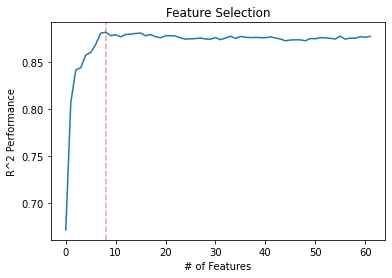

<IPython.core.display.Javascript object>

In [97]:
plot_scores(scores=scores, vline_val=8)

Optimal number of features is 8

In [104]:
def plot_feature_importance(model, X_train, n_features=35):
    sorted_importance = sorted(
        zip(X_train.columns, model.feature_importances_),
        key=lambda t: t[1],
        reverse=True,
    )

    # Get data for the plot (n_features based on your preference)
    a, b = zip(*sorted_importance[:n_features])
    df = pd.DataFrame({"feature_name": a, "importance_score": b})

    # Plot

    plt.rcParams["figure.autolayout"] = True
    plt.subplots_adjust(bottom=0.15)

    plt.figure(figsize=(20, 10))
    df.plot.bar(x="feature_name", y="importance_score", legend=None)
    plt.title("Feature Importance")

    plt.savefig("../pic/feature_importances_bar.png", dpi=900)
    plt.show()

<IPython.core.display.Javascript object>

In [19]:
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

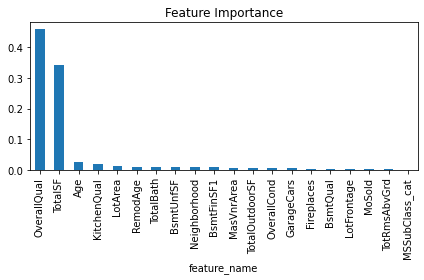

<IPython.core.display.Javascript object>

In [107]:
plot_feature_importance(random_forest_model, X_train, n_features=20)

## Comparing Models of Optimal Features Vs All Features

In [21]:
def compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count):
    # All features
    model.fit(X_train, y_train)
    all_features_score = model.score(X_test, y_test)

    # Optimal features
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features][:optimal_features_count]

    X_train_optimal = X_train[selected_columns]
    X_test_optimal = X_test[selected_columns]

    model.fit(X_train_optimal, y_train)
    optimal_features_score = model.score(X_test_optimal, y_test)

    return all_features_score, optimal_features_score

<IPython.core.display.Javascript object>

In [22]:
model = RandomForestRegressor(random_state=0)
optimal_features_count = 8  # This from the plot_scores function
all_features_score, optimal_features_score = compare_models(
    model, X_train, y_train, X_test, y_test, optimal_features_count
)

print("R^2 score using all features: ", all_features_score)
print("R^2 score using optimal features: ", optimal_features_score)

R^2 score using all features:  0.9085632354080178
R^2 score using optimal features:  0.9022877721760434


<IPython.core.display.Javascript object>

The scores show that using all features is best and this is also what the plot shows

## Checking for Overfitting by Looking at the Train and Test Errors

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared error for the train and test sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate the R^2 for the train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("The training error (MSE) is: %.5f" % mse_train)
    print("The test     error (MSE) is: %.5f" % mse_test)
    print("The training R^2 is: %.5f" % r2_train)
    print("The test     R^2 is: %.5f" % r2_test)

<IPython.core.display.Javascript object>

In [24]:
random_forest_model = RandomForestRegressor(random_state=0)
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

The training error (MSE) is: 83862883.22620
The test     error (MSE) is: 541415051.26975
The training R^2 is: 0.98482
The test     R^2 is: 0.90856


<IPython.core.display.Javascript object>

Model is overfitting

# Tuning the Hyper Parameters

In [25]:
# This code is using better parameters and result in a higher test score and lower training score

from sklearn.model_selection import RandomizedSearchCV


def find_best_params(X_train, y_train):
    param_grid = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [10, 20, 30, 40, 50, 60],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [4, 8, 12],
        "max_features": ["auto", "sqrt"],
    }

    rf = RandomForestRegressor(random_state=0)
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
        random_state=0,
    )

    randomized_search.fit(X_train, y_train)

    return randomized_search.best_params_


best_params = find_best_params(X_train, y_train)
print("Best parameters found by RandomizedSearchCV:")
print(best_params)

best_rf = RandomForestRegressor(**best_params, random_state=0)

evaluate_model(best_rf, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found by RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60}
The training error (MSE) is: 228388361.45073
The test     error (MSE) is: 526175096.27153
The training R^2 is: 0.95867
The test     R^2 is: 0.91114


<IPython.core.display.Javascript object>

## Vizualizing Tuned Parameters

In [83]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [40, 50, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [4, 8, 12],
    "max_features": ["auto", "sqrt"],
}

rf = RandomForestRegressor(random_state=0)
best_rf_GS = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_squared_error",
    random_state=0,
)
best_rf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [40, 50, 60],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 8, 12],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=2)

<IPython.core.display.Javascript object>

In [84]:
best_rf_GS.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 50}

<IPython.core.display.Javascript object>

#### max_depth and n_estimators

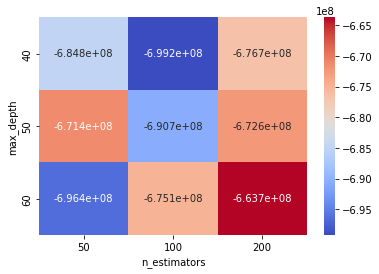

<IPython.core.display.Javascript object>

In [85]:
results = pd.DataFrame(best_rf_GS.cv_results_)
table = pd.pivot_table(
    results,
    values="mean_test_score",
    index="param_max_depth",
    columns="param_n_estimators",
)
sns.heatmap(
    table,
    annot=True,
    fmt=".4g",
    cmap="coolwarm",
    cbar_kws={"format": ticker.ScalarFormatter(useMathText=False)},
)

plt.xlabel("n_estimators")
plt.ylabel("max_depth")

plt.savefig("../pic/max_depth-n_estimators-heatmap.png", dpi=900)
plt.show()

#### min_samples_split

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_fe

[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END max_depth=60, max_features=au

[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=50, max_features

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimator

[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features

[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.8s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, max_features=

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=

[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=60, max_features=au

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=a

[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=a

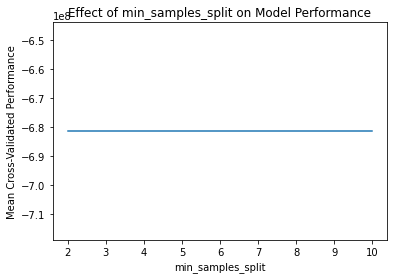

<IPython.core.display.Javascript object>

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter values to test
min_samples_split_values = [2, 5, 10]

# Initialize an empty list to store the mean cross-validated performance
mean_scores = []

# Loop over each value of min_samples_split and compute the mean cross-validated performance
for min_samples_split in min_samples_split_values:
    rf = RandomForestRegressor(random_state=0, min_samples_split=min_samples_split)
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
        random_state=0,
    )
    randomized_search.fit(X_train, y_train)
    mean_score = np.mean(randomized_search.cv_results_['mean_test_score'])
    mean_scores.append(mean_score)

# Plot the results
plt.plot(min_samples_split_values, mean_scores)
plt.xlabel('min_samples_split')
plt.ylabel('Mean Cross-Validated Performance')
plt.title('Effect of min_samples_split on Model Performance')
plt.show()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


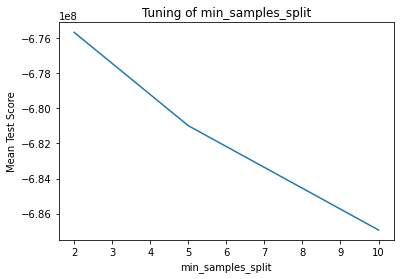

<IPython.core.display.Javascript object>

In [87]:
# Extract the results from the GridSearchCV object
results = pd.DataFrame(best_rf_GS.cv_results_)

# Filter the results for the min_samples_split hyperparameter
min_samples_split_results = results[["param_min_samples_split", "mean_test_score"]]

# Convert the min_samples_split hyperparameter values to numeric
min_samples_split_results["param_min_samples_split"] = pd.to_numeric(
    min_samples_split_results["param_min_samples_split"]
)

# Group the results by min_samples_split and calculate the mean test score
min_samples_split_results = min_samples_split_results.groupby(
    "param_min_samples_split"
).mean()

# Reset the index
min_samples_split_results = min_samples_split_results.reset_index()

# Plot the results as a line plot
sns.lineplot(
    x="param_min_samples_split",
    y="mean_test_score",
    data=min_samples_split_results,
)
plt.xlabel("min_samples_split")
plt.ylabel("Mean Test Score")
plt.title("Tuning of min_samples_split")

plt.savefig("../pic/min_samples_split_tuning.png", dpi=900)
plt.show()


#### min_samples_leaf


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


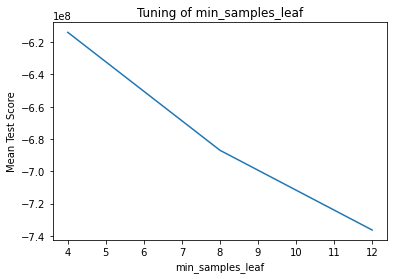

<IPython.core.display.Javascript object>

[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=60, max_features

[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=40, max_features

[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=50; total time=   0.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=50, max_features=

[CV] END max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=12, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=40, max_features=auto

[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=40, max_features=

[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END max_depth=60, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=60, max_features=a

In [89]:
# Extract the results from the GridSearchCV object
results = pd.DataFrame(best_rf_GS.cv_results_)

# Filter the results for the min_samples_leaf hyperparameter
min_samples_leaf_results = results[["param_min_samples_leaf", "mean_test_score"]]

# Convert the min_samples_leaf hyperparameter values to numeric
min_samples_leaf_results["param_min_samples_leaf"] = pd.to_numeric(
    min_samples_leaf_results["param_min_samples_leaf"]
)

# Group the results by min_samples_leaf and calculate the mean test score
min_samples_leaf_results = min_samples_leaf_results.groupby(
    "param_min_samples_leaf"
).mean()

# Reset the index
min_samples_leaf_results = min_samples_leaf_results.reset_index()

# Use .loc to assign the mean test score to the DataFrame
min_samples_leaf_results.loc[:, "mean_test_score"] = min_samples_leaf_results["mean_test_score"]

# Plot the results as a line plot
sns.lineplot(
    x="param_min_samples_leaf",
    y="mean_test_score",
    data=min_samples_leaf_results,
)
plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Test Score")
plt.title("Tuning of min_samples_leaf")

plt.savefig("../pic/min_samples_leaf_tuning.png", dpi=900)
plt.show()


## StackingRegressor brings test score up to .927 and training score down to .947

In [26]:




from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

# Define the base estimators
base_estimators = [
    ('rf', RandomForestRegressor(**best_params, random_state=0)),
    ('ridge', Ridge(random_state=0)),
    ('svr', SVR(kernel='linear'))
]

# Create the stacking regressor
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=Ridge(random_state=0))

# Evaluate the stacking regressor
evaluate_model(stacking_regressor, X_train, y_train, X_test, y_test)


The training error (MSE) is: 285685746.61138
The test     error (MSE) is: 423609991.18574
The training R^2 is: 0.94830
The test     R^2 is: 0.92846


<IPython.core.display.Javascript object>

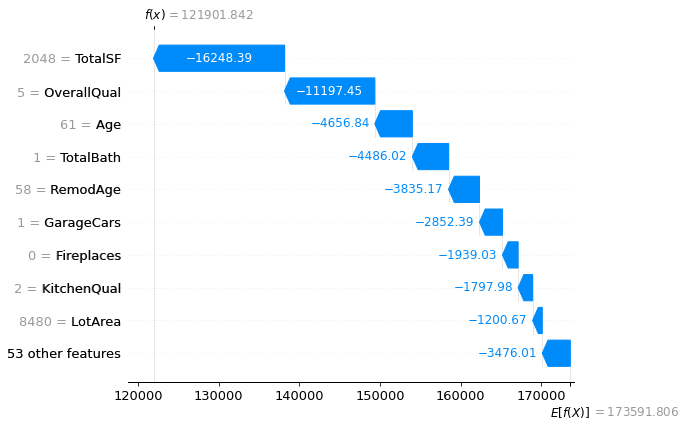

<IPython.core.display.Javascript object>

In [27]:
# WATERFALL WITH STACKING REGRESSOR

# Fit the stacking regressor
stacking_regressor.fit(X_train, y_train)

# Get the RandomForestRegressor within the stacking regressor
rf_stacking = stacking_regressor.named_estimators_['rf']

# Create a SHAP explainer for the RandomForest model within the stacking regressor
explainer_stacking = shap.Explainer(rf_stacking, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 0

# Get the SHAP values for the specified instance in X_train
shap_values_instance_stacking = explainer_stacking(X_train.iloc[instance_index : instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
shap.plots.waterfall(shap_values_instance_stacking[0])


In [28]:
# OLD CODE  DELETE

# from sklearn.model_selection import RandomizedSearchCV

# def find_best_params(X_train, y_train):
#     param_grid = {
#         'n_estimators': [10, 50, 100, 200],
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'max_features': ['auto', 'sqrt']
#     }

#     rf = RandomForestRegressor(random_state=0)
#     randomized_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', random_state=0)

#     randomized_search.fit(X_train, y_train)

#     return randomized_search.best_params_

# best_params = find_best_params(X_train, y_train)
# print("Best parameters found by RandomizedSearchCV:")
# print(best_params)

# best_rf = RandomForestRegressor(**best_params, random_state=0)
# evaluate_model(best_rf, X_train, y_train, X_test, y_test)


<IPython.core.display.Javascript object>

# Using Shap to look at the features that contributed the most to the SalePrice

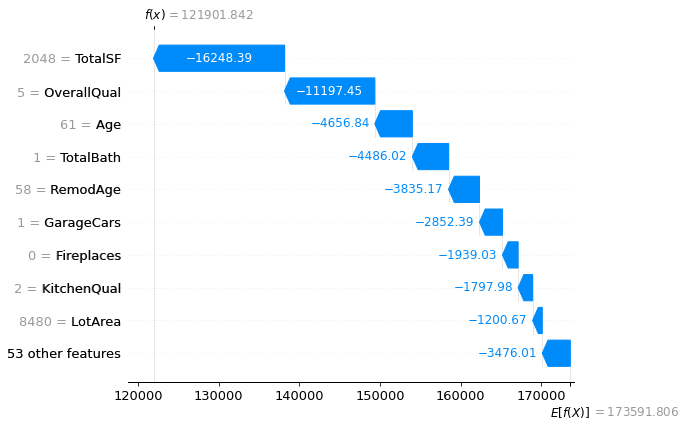

<IPython.core.display.Javascript object>

In [29]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 0

# Get the SHAP values for the specified instance in X_train
shap_values_instance = explainer(X_train.iloc[instance_index : instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
# A waterfall plot helps visualize the contribution of each feature to the final prediction for the instance
shap.plots.waterfall(shap_values_instance[0])

## SHAP for total bathrooms

 99%|===================| 2026/2046 [00:53<00:00]        

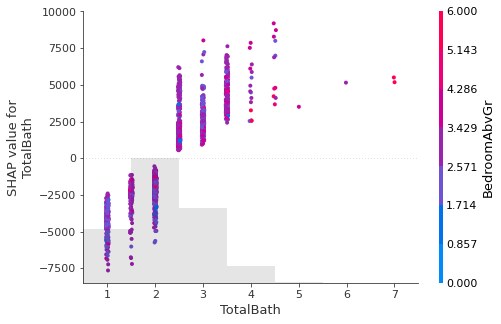

<IPython.core.display.Javascript object>

In [30]:
# Looking at the interaction of total bathrooms and total bedrooms

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Plot the interaction between TotalBath and BedroomAbvGr
shap.plots.scatter(shap_values[:, "TotalBath"], color=shap_values[:, "BedroomAbvGr"])

plt.show()

It looks like there are a few plots where the value in TotalBath contributes to more than $10,0000
of the saleprice

In [31]:
# Finding indices of observations with a SHAP value for TotalBath greater than 10000
high_shap_indices = np.where(shap_values[:, X_train.columns.get_loc("TotalBath")].values > 10000)[0]

print("Indices of observations with high SHAP values for TotalBath:", high_shap_indices)


Indices of observations with high SHAP values for TotalBath: []


<IPython.core.display.Javascript object>

In [32]:
# Plot the SHAP values as a waterfall plot for each high-value observation
for index in high_shap_indices:
    shap_values_instance = explainer(X_train.iloc[index:index + 1, :])
    shap.plots.waterfall(shap_values_instance[0])
    plt.show()


<IPython.core.display.Javascript object>

 99%|===================| 2017/2046 [00:53<00:00]        

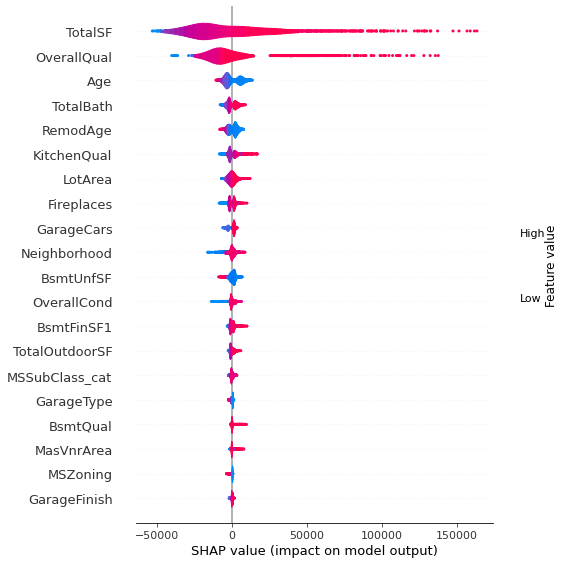

<IPython.core.display.Javascript object>

In [33]:
# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Get the base value (expected value) from the explainer
base_value = shap_values.base_values

# Set the expected_value attribute for the SHAP values
shap_values.expected_value = base_value

# Plot the SHAP violin plot for all features
shap.plots.violin(shap_values)



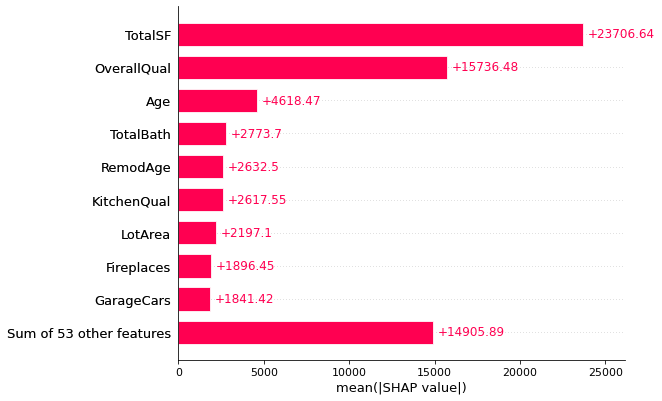

<IPython.core.display.Javascript object>

In [34]:
shap.plots.bar(shap_values)

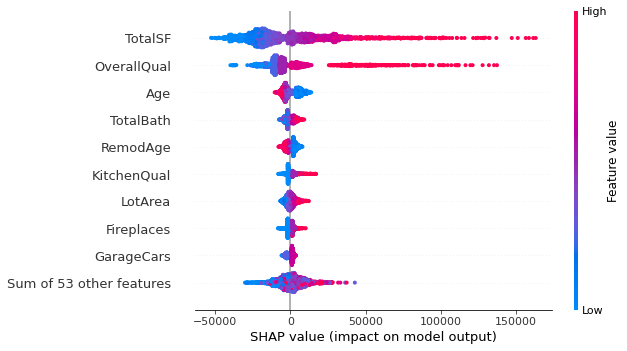

<IPython.core.display.Javascript object>

In [35]:
shap.plots.beeswarm(shap_values)

Using the explainer that was created above I will now try to answer a few questions

## SHAP for KitchQual

 99%|===================| 2027/2046 [00:53<00:00]        

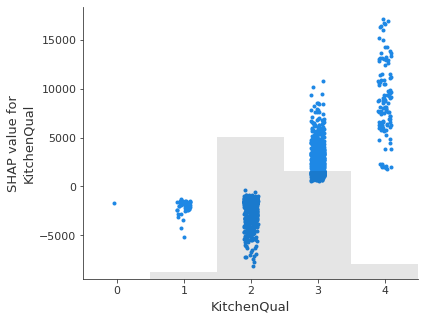

<IPython.core.display.Javascript object>

In [36]:
# Looking at how KitchenQual variables affect Shap Values

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Plot the interaction ShapValues of KitchenQual
shap.plots.scatter(shap_values[:, "KitchenQual"])

plt.show()

 99%|===================| 2028/2046 [00:53<00:00]        

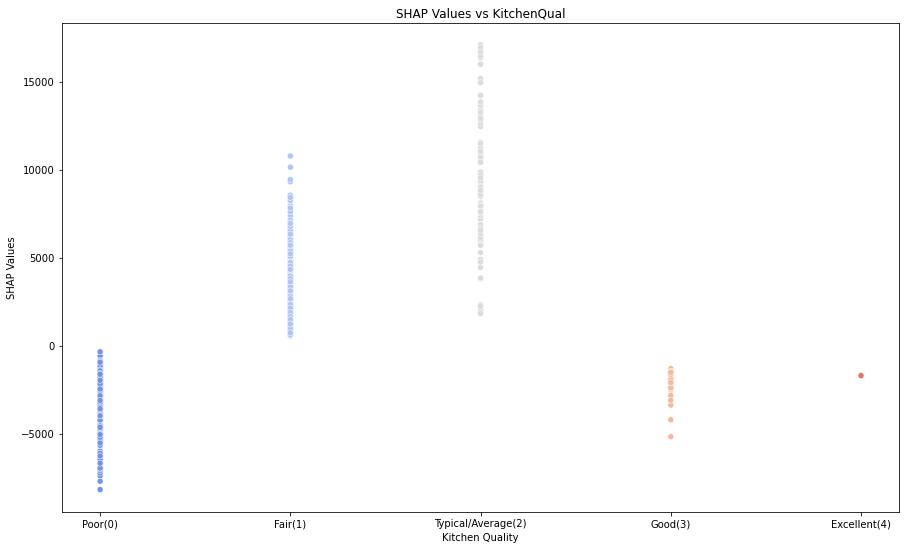

<IPython.core.display.Javascript object>

In [49]:
# Different plot showing range in values for Kitchen Quality


# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Data preparation for plotting
kitchen_qual_labels = ["Poor(0)", "Fair(1)", "Typical/Average(2)", "Good(3)", "Excellent(4)"]
shap_values_df_labels = shap_values[:, "KitchenQual"].values
shap_values_df_labels = pd.DataFrame({"KitchenQual": X_train["KitchenQual"], "value": shap_values_df_labels})
shap_values_df_labels["KitchenQual"] = shap_values_df_labels["KitchenQual"].map({i: kitchen_qual_labels[i] for i in range(5)})

# Scatter Plot
plt.figure(figsize=(15, 9))
scatter_plot = sns.scatterplot(data=shap_values_df_labels, x="KitchenQual", y="value", hue="KitchenQual", palette="coolwarm", legend=None)
plt.title("SHAP Values vs KitchenQual")
plt.xlabel("Kitchen Quality")
plt.ylabel("SHAP Values")
plt.xticks(range(5), kitchen_qual_labels)
plt.show()


In [50]:
X_train.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'PavedDrive', 'Fence',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Age', 'RemodAge',
       'TotalSF', 'Remodeled', 'TotalBath', 'MSSubClass_cat', 'Street_type',
       'TotalOutdoorSF'],
      dtype='object')

<IPython.core.display.Javascript object>

# Some houses have more than one Kitchen.  Should we look into this?

In [51]:
housing["KitchenAbvGr"].value_counts()

1    2451
2     104
0       2
3       1
Name: KitchenAbvGr, dtype: int64

<IPython.core.display.Javascript object>

In [52]:
X_train["KitchenAbvGr"].value_counts()

1    1957
2      86
0       2
3       1
Name: KitchenAbvGr, dtype: int64

<IPython.core.display.Javascript object>

# Looks like Shap values are low for this feature. Im assuming the -1085 is for when there is no kitchen

In [53]:
shap_values_df["KitchenAbvGr"].describe()


NameError: name 'shap_values_df' is not defined

<IPython.core.display.Javascript object>

In [ ]:
# Finding indices of observations with a SHAP value for KitchenQual greater than 14000
high_shap_indices = np.where(
    shap_values[:, X_train.columns.get_loc("KitchenQual")].values > 14000
)[0]

print(
    "Indices of observations with high SHAP values for KitchenQual:", high_shap_indices
)

# Plot the SHAP values as a waterfall plot for each high-value observation
for index in high_shap_indices:
    shap_values_instance = explainer(X_train.iloc[index : index + 1, :])
    shap.plots.waterfall(shap_values_instance[0])
    plt.show()

## Did home buyers value a half bathroom in the basement less than in a floor above ground? Was there more of a value on outdoor space in the summer months?

In [ ]:
# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Convert the SHAP values to a DataFrame for easier analysis
shap_values_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# Add the 'MoSold' column to the SHAP values DataFrame
shap_values_df['MoSold'] = X_train['MoSold'].values

# Calculate the average SHAP value for BsmtHalfBath and HalfBath
avg_shap_BsmtHalfBath = shap_values_df['BsmtHalfBath'].mean()
avg_shap_HalfBath = shap_values_df['HalfBath'].mean()

print("Average SHAP value for BsmtHalfBath:", avg_shap_BsmtHalfBath)
print("Average SHAP value for HalfBath:", avg_shap_HalfBath)

# Define a function to categorize months into summer and non-summer
def is_summer(month):
    return month in [6, 7, 8]

# Create a new column 'IsSummer' in the SHAP values DataFrame
shap_values_df['IsSummer'] = shap_values_df['MoSold'].apply(is_summer)

# Calculate the average SHAP value for TotalOutdoorSF in summer and non-summer months
avg_shap_TotalOutdoorSF_summer = shap_values_df.loc[shap_values_df['IsSummer'], 'TotalOutdoorSF'].mean()
avg_shap_TotalOutdoorSF_non_summer = shap_values_df.loc[~shap_values_df['IsSummer'], 'TotalOutdoorSF'].mean()

print("Average SHAP value for TotalOutdoorSF in summer months:", avg_shap_TotalOutdoorSF_summer)
print("Average SHAP value for TotalOutdoorSF in non-summer months:", avg_shap_TotalOutdoorSF_non_summer)


The above negative numbers means something was done wrong.  Maybe TotalOutdoorSF and the half baths should be a binary of yes or no?

### Im going to look into a few other shap values.  Now that there I have the dataframe (shap_values_df) of shap values i can explore the values more

In [ ]:
# Adding the original values as a column to the dataframe of shap values which will allow me to 
# look at the average shap values for differen values in the Totalbath column
shap_values_df['TotalBath_values'] = X_train['TotalBath'].values

for i in range(1, 7):
    avg_shap_TotalBath = shap_values_df.loc[shap_values_df['TotalBath_values'] == i, 'TotalBath'].mean()
    print(f"Average SHAP value for TotalBath {i}: {avg_shap_TotalBath}")

# Drop the 'TotalBath_values' column
shap_values_df.drop(columns=['TotalBath_values'], inplace=True)


The numbers for the totalbath look more promising.  Im assuming there is a negative shap value for 1 and 2 bathrooms because the house is large(with a lot of bedrooms) and there needs to be a higher amount of bathrooms
to handle the extra loads!

In [ ]:

# Im doing the same thing to look at the average shap values for a house remodeled and not remodeled
shap_values_df['Remodeled_values'] = X_train['Remodeled'].values

for i in [0, 1]:
    avg_shap_Remodeled = shap_values_df.loc[shap_values_df['Remodeled_values'] == i, 'Remodeled'].mean()
    print(f"Average SHAP value for Remodeled {i}: {avg_shap_Remodeled}")

# Drop the 'Remodeled_values' column
shap_values_df.drop(columns=['Remodeled_values'], inplace=True)


Not much of a difference here.  This might be because we are looking at the average of all of the observations instead of just looking at similiar properties. For example, is there much of a difference in sale price when 
most of the other features are similiar and the homes were built around the same time?

In [ ]:
# I'm now doing the same thing with functional value
shap_values_df['Functional_values'] = X_train['Functional'].values
unique_functional_values = X_train['Functional'].unique()

for value in unique_functional_values:
    avg_shap_Functional = shap_values_df.loc[shap_values_df['Functional_values'] == value, 'Functional'].mean()
    print(f"Average SHAP value for Functional '{value}': {avg_shap_Functional}")

# Drop the 'Functional_values' column
shap_values_df.drop(columns=['Functional_values'], inplace=True)


## The house value decreases a lot when the functionality is zero which should be a house that is Salvage only as defined below
Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

Odd that there is only 7 values in my dataset even though the dictionary that came with the dataset shows 8 different variables.  Ill look at the original dataset to explore further

In [ ]:
# Loading original dataframe
df = pd.read_csv("../data/housing_cleaned.csv")
# Printing values for functional column
df["Functional"].value_counts()

Looks like there is no Sev (severly damaged) in the dataset.  It also looks like there is only one Sal(Salvage only) so if the test train is split differently it wouldnt show up in this part of the data

## Looking at the average shap value for features (such as if a home was remodeled) doesnt make much sense unless we are looking at similiar properties.  This is where  Cosine similarity is useful....

To compare similiar homes I will:

1. Choose the features I want to consider for similarity (e.g., TotalSF, OverallQual, YearBuilt).
2. Normalize the selected features.
3. Calculate the cosine similarity between each pair of homes.
4. Find similar homes based on a similarity threshold or by selecting the top N most similar homes.
5. Compare the average SHAP values for remodeled and non-remodeled homes within the similar homes group.

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Reset the indices of X_train and shap_values_df
X_train.reset_index(drop=True, inplace=True)
shap_values_df.reset_index(drop=True, inplace=True)

# Select features to use for similarity
features = ['TotalSF', 'Age', 'Neighborhood', 'TotalBath']
X_similarity = X_train[features]

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_similarity)

# Calculate cosine similarity between each pair of homes
cosine_sim = cosine_similarity(X_normalized)

# Set a similarity threshold or select the top N most similar homes
similarity_threshold = 0.95

# Add Remodeled column to X_train to filter by remodeled status later
X_train['Remodeled'] = X_train['Remodeled'].values

# Re-index the shap_values_df DataFrame to match X_train's index
# shap_values_df = shap_values_df.loc[X_train.index]

# Loop through each home and find similar homes
similar_homes = []
for index, similarities in enumerate(cosine_sim):
    # Get the indices of similar homes
    similar_indices = [i for i, sim in enumerate(similarities) if sim >= similarity_threshold and i != index]
    
    if similar_indices:
        # Get the original indices in X_train
        similar_original_indices = X_train.iloc[similar_indices].index
        # Add the current home index and its similar homes indices
        similar_homes.append((X_train.index[index], similar_original_indices))

# Calculate the average SHAP values for remodeled and non-remodeled homes within the similar homes group
remodeled_shap_values = []
non_remodeled_shap_values = []

for home, similar_indices in similar_homes:
    for idx in similar_indices:
        if X_train.loc[idx, 'Remodeled'] == 1:
            remodeled_shap_values.append(shap_values_df.loc[idx, 'Remodeled'])
        else:
            non_remodeled_shap_values.append(shap_values_df.loc[idx, 'Remodeled'])

avg_shap_remodeled = sum(remodeled_shap_values) / len(remodeled_shap_values)
avg_shap_non_remodeled = sum(non_remodeled_shap_values) / len(non_remodeled_shap_values)

print(f"Average SHAP value for similar remodeled homes: {avg_shap_remodeled}")
print(f"Average SHAP value for similar non-remodeled homes: {avg_shap_non_remodeled}")


### It looks like this has very little effect however that is most likely because our model does not give high SHAP values for the binary remodeled feature.  This could be because our model also factors the condition and quality of items that can be remodeled

## Going back to the number of bathrooms I will now look at how the SHAP values of KitchenQual changes when looking at the size of a home

In [ ]:
# First i want to look at how many larger homes are in the dataset
X_train[X_train["TotalSF"] > 3000].count()

In [ ]:
# Add the 'TotalSf_values' column to the shap_values_df DataFrame
shap_values_df['TotalSF_values'] = X_train['TotalSF'].values

# Filter the shap_values_df DataFrame based on the 'TotalSf_values' column
shap_values_df_filtered = shap_values_df[shap_values_df['TotalSF_values'] > 3000].copy()

# Add the 'KitchenQual_values' column to the filtered shap_values_df DataFrame
shap_values_df_filtered['KitchenQual_values'] = X_train.loc[shap_values_df_filtered.index, 'KitchenQual'].values

# Calculate the average SHAP value for each KitchenQual
for i in range(0, 5):
    avg_shap_KitchenQual = shap_values_df_filtered.loc[shap_values_df_filtered['KitchenQual_values'] == i, 'KitchenQual'].mean()
    print(f"Average SHAP value for KitchenQual {i}: {avg_shap_KitchenQual}")

# Drop the 'TotalSf_values' and 'TotalBath_values' columns
shap_values_df_filtered.drop(columns=['TotalSF_values', 'KitchenQual_values'], inplace=True)


Great!  This shows there is an average SHAP penalty of $3,724 in homes over 3000 SF with KitchenQual of 1

## It looks like the penalty for having a poor quality kitchen in a smaller home is less which makes sense

In [ ]:
# Add the 'TotalSf_values' column to the shap_values_df DataFrame
shap_values_df["TotalSF_values"] = X_train["TotalSF"].values

# Filter the shap_values_df DataFrame based on the 'TotalSf_values' column
shap_values_df_filtered = shap_values_df[shap_values_df["TotalSF_values"] < 1500].copy()

# Add the 'KitchenQual_values' column to the filtered shap_values_df DataFrame
shap_values_df_filtered["KitchenQual_values"] = X_train.loc[
    shap_values_df_filtered.index, "KitchenQual"
].values

# Calculate the average SHAP value for each KitchenQual
for i in range(0, 5):
    avg_shap_KitchenQual = shap_values_df_filtered.loc[
        shap_values_df_filtered["KitchenQual_values"] == i, "KitchenQual"
    ].mean()
    print(f"Average SHAP value for KitchenQual {i}: {avg_shap_KitchenQual}")

# Drop the 'TotalSf_values' and 'TotalBath_values' columns
shap_values_df_filtered.drop(
    columns=["TotalSF_values", "KitchenQual_values"], inplace=True
)

In [ ]:
shap_values_df

# Im now going to look into the 10 observations that have the highest SHAP value in the KitchenQual column.  I will then look at the other features of these 10 observations to find out what is similiar.  

In [ ]:
# First im looking at the value counts of the original dataframe
df["KitchenQual"].value_counts()

In [ ]:
# Looking at the 10 observations where KitchenQual has the largest shap value.  Value range here is
# 15,341 - 20,452
shap_values_df.nlargest(10, "KitchenQual")


Looking at the top 10 descriptive stats vs the rest of the dataset

In [ ]:
# Get the indices of the top 10 observations with the highest SHAP values for "KitchenQual"
top_10_indices = shap_values_df.nlargest(10, "KitchenQual").index

# Get the corresponding 10 observations in the X_train DataFrame
top_10_observations = X_train.loc[top_10_indices]

# Get the descriptive statistics for the top 30 observations
top_10_stats = top_10_observations.describe()

# Get the descriptive statistics for the rest of the X_train DataFrame
rest_of_X_train_stats = X_train.drop(top_10_indices).describe()

# Compare the descriptive statistics of both sets of observations
comparison = pd.concat([top_10_stats, rest_of_X_train_stats], axis=1, keys=['Top 10', 'Rest of X_train'])

comparison


In [ ]:
top_10_stats

The 10 observations that are mostly similar are street type, alley, utilities, building type, heating, heating quality, central air, electrical system, and the number of kitchens above grade. 

The features that are not similiar are lot frontage, lot area, basement finish square footage, mas masonry veneer area, and total outdoor square footage, among other features.

## Are the similiar features significant when compared to the rest of the dataset?

In [ ]:

from scipy.stats import ttest_ind

# Assuming you have the top 30 observations and the entire X_train data as DataFrames
top_10_df = top_10_observations
x_train_df = X_train.drop(top_10_indices)

# List to store the names of significantly different features
significant_features = []

# Perform a two-sample t-test for each feature
for column in top_10_df.columns:
    t_stat, p_value = ttest_ind(top_10_df[column], x_train_df[column])
    
    # Check for significance (usually a significance level of 0.05 is used)
    if p_value < 0.0000005:
        significant_features.append(column)

# Print the significantly different features
print("Significantly different features:")
for feature in significant_features:
    print(feature)


# Looking at the values of the significant in the Top 10 and again at the rest of the dataset

In [ ]:
# List of features I'm interested in
features = [
    "LotArea", "OverallQual", "RoofStyle", "MasVnrArea", "BsmtFinSF1",
    "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
    "TotalSF", "TotalBath", "TotalOutdoorSF"
]

# Getting the summary statistics for the selected features
summary_stats = top_10_observations[features].describe()

# Filter only the min, max, and mean rows from the summary statistics
summary_stats.loc[["min", "max", "mean"]]



In [ ]:
# List of features you're interested in
features = [
    "LotArea", "OverallQual", "RoofStyle", "MasVnrArea", "BsmtFinSF1",
    "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
    "TotalSF", "TotalBath", "TotalOutdoorSF"
]

all_the_rest = X_train.drop(top_10_indices)

# Get the summary statistics for the selected features
summary_stats = all_the_rest[features].describe()

# Filter only the min, max, and mean rows from the summary statistics
summary_stats.loc[["min", "max", "mean"]]



# So it looks like larger houses that are worth more money have a larger SHAP value for KitchenQual. Something that should of been obvious but i will leave the code here in case i want to look at something that is less obvious using a similiar process

In [ ]:
X_train

In [ ]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 576

# Get the SHAP values for the specified instance in X_train
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
# A waterfall plot helps visualize the contribution of each feature to the final prediction for the instance
shap.plots.waterfall(shap_values_instance[0],max_display=20)



In [ ]:
# Check the current value of the KitchenQual variable for index 576
current_value = X_train.loc[576, 'KitchenQual']
print("Current value of KitchenQual for index 576:", current_value)


In [ ]:
# Modify the KitchenQual variable for the specified instance
X_train.loc[576, 'KitchenQual'] = 2

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the modified instance
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the modified instance
shap.plots.waterfall(shap_values_instance[0],max_display=20)


In [ ]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Extract the SHAP values for index 576
shap_values_576 = shap_values[576]

# Print the SHAP values for index 576
print("SHAP values for index 576:\n", shap_values_576)


In [ ]:
# Modify the KitchenQual variable for the specified instance
X_train.loc[576, 'KitchenQual'] = 4

# Create a SHAP explainer for the RandomForest model
explainer = shap.TreeExplainer(best_rf, X_train)

# Calculate SHAP values for the modified instance
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the modified instance
shap.plots.waterfall(shap_values_instance[0],max_display=20)


In [ ]:
shap_values_df.loc[576, :]

## Which Neighborhood to Target for Kitchen Remodel

In [ ]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.TreeExplainer(best_rf, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train)

In [ ]:
Neighborhood_mapping = {
    "SWISU": 0,
    "Edwards": 1,
    "IDOTRR": 2,
    "OldTown": 3,
    "NWAmes": 4,
    "Blmngtn": 5,
    "Mitchel": 6,
    "NridgHt": 7,
    "NAmes": 8,
    "CollgCr": 9,
    "SawyerW": 10,
    "MeadowV": 11,
    "BrDale": 12,
    "Gilbert": 13,
    "Timber": 14,
    "Somerst": 15,
    "BrkSide": 16,
    "NoRidge": 17,
    "Sawyer": 18,
    "Crawfor": 19,
    "Greens": 20,
    "ClearCr": 21,
    "StoneBr": 22,
    "Veenker": 23,
    "NPkVill": 24,
    "Blueste": 25,
}


In [ ]:
# OLD CODE SHOWING FLOATS INSTEAD OF STRINGS PER NEIGHBORHOOD. - DELETE

# shap_w_neighborhoods = pd.DataFrame(shap_values, columns=X_train.columns)
# shap_w_neighborhoods["NeighborhoodGrouped"] = X_train["Neighborhood"]
# shap_w_neighborhoods["KitchenQualGrouped"] = X_train["KitchenQual"]

# # Moving KitchenQual to First Column
# shap_w_neighborhoods.insert(0, "KitchenQual", shap_w_neighborhoods.pop("KitchenQual"))
# shap_w_neighborhoods.insert(
#     1, "KitchenQualGrouped", shap_w_neighborhoods.pop("KitchenQualGrouped")
# )
# shap_w_neighborhoods.insert(
#     2, "NeighborhoodGrouped", shap_w_neighborhoods.pop("NeighborhoodGrouped")
# )

# # Grouping by Neighborhood and getting average Kitchen Values
# shap_grouped = shap_w_neighborhoods.groupby(by="NeighborhoodGrouped")
# shap_grouped_avg = shap_grouped.mean().sort_values(by="KitchenQual", ascending=False)[
#     ["KitchenQual"]
# ]
# shap_grouped_avg

In [ ]:
# Adding back the Neighborhood Grouping to Shap dataframe
shap_w_neighborhoods = pd.DataFrame(shap_values, columns=X_train.columns)
shap_w_neighborhoods["NeighborhoodGrouped"] = X_train["Neighborhood"]
shap_w_neighborhoods["KitchenQualGrouped"] = X_train["KitchenQual"]

# Moving KitchenQual to First Column
shap_w_neighborhoods.insert(0, "KitchenQual", shap_w_neighborhoods.pop("KitchenQual"))
shap_w_neighborhoods.insert(
    1, "KitchenQualGrouped", shap_w_neighborhoods.pop("KitchenQualGrouped")
)
shap_w_neighborhoods.insert(
    2, "NeighborhoodGrouped", shap_w_neighborhoods.pop("NeighborhoodGrouped")
)

# Inverting the Neighborhood_mapping dictionary so that it maps from float values to string values:
inverse_neighborhood_mapping = {v: k for k, v in Neighborhood_mapping.items()}

# Applying the mapping to the NeighborhoodGrouped column
shap_w_neighborhoods["NeighborhoodGrouped"] = shap_w_neighborhoods["NeighborhoodGrouped"].map(inverse_neighborhood_mapping)

# Grouping by Neighborhood and getting average Kitchen Values
shap_grouped = shap_w_neighborhoods.groupby(by="NeighborhoodGrouped")
shap_grouped_avg = shap_grouped.mean().sort_values(by="KitchenQual", ascending=False)[["KitchenQual"]]

shap_grouped_avg


In [ ]:
# Looking at the numbers in a bar chart

# Set the plot size
plt.figure(figsize=(12, 6))

# Create the bar chart
plt.bar(shap_grouped_avg.index, shap_grouped_avg['KitchenQual'])

# Set the chart labels and title
plt.xlabel('Neighborhood Grouped')
plt.ylabel('Average KitchenQual SHAP Value')
plt.title('Average KitchenQual SHAP Value by Neighborhood')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Compute the average KitchenQual value for each neighborhood in X_train
avg_kitchen_qual = X_train.groupby("Neighborhood")["KitchenQual"].mean()

# Map the neighborhood numbers in X_train back to the neighborhood names
avg_kitchen_qual.index = avg_kitchen_qual.index.map(inverse_neighborhood_mapping)

# Create a colormap and a normalization instance
cmap = plt.cm.get_cmap("viridis")
norm = mcolors.Normalize(vmin=avg_kitchen_qual.min(), vmax=avg_kitchen_qual.max())

# Set the plot size
plt.figure(figsize=(18, 9))

# Create the bar chart with colors based on the average KitchenQual values
plt.bar(shap_grouped_avg.index, shap_grouped_avg['KitchenQual'], color=cmap(norm(avg_kitchen_qual.loc[shap_grouped_avg.index])))

# Set the chart labels and title
plt.xlabel('Neighborhood Grouped')
plt.ylabel('Average KitchenQual SHAP Value')
plt.title('Average KitchenQual SHAP Value by Neighborhood')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a colorbar to show the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Average KitchenQual Values')

# Display the plot
plt.show()


In [ ]:
avg_kitchen_qual


In [ ]:
shap_grouped_avg

In [ ]:
# Top 10
shap_grouped_avg.nlargest(10, "KitchenQual")

In [ ]:
# Bottom 10
shap_grouped_avg.nsmallest(10, "KitchenQual")

### ^How Do I  Match # with Neighborhood Names^

## Neighborhood Breakdown

In These neighborhoods where kitchens are weighed heavily, we find the lower quality kitchens and target them for renovation showing the client that they specifically have the most to benefit in this specific neighborhood \n specifically the quality 2

In [ ]:
# 17
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == "NoRidge"].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

In [ ]:
# Changing the KithenQual for this specified instance back to its original value
X_train.loc[576, "KitchenQual"] = 4

In [ ]:
# 23
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == "Veenker"].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

In [ ]:
# 16
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == "BrkSide"].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

In [ ]:
# 25
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == "Blueste"].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

In [ ]:
# 22
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == "StoneBr"].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

In [ ]:
# looking at the observations with a 1 Kitchen Quality
X_train.iloc[[1731, 207, 1562, 836, 1251], :]

### Looks like a few have overal quality of 6 and one has over all condition of 8, they all have "AdjLand": This indicates that the property is adjacent to land that has a different use, such as a park or commercial property.

In [ ]:
X_train["SaleCondition"].value_counts()

In [ ]:
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == "Crawfor"].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

# What a kitchen looks like for each of the 5 variables


Excellent: In a kitchen with an "Excellent" quality rating, you might expect to find high-end appliances and finishes, such as stainless steel appliances, granite countertops, and custom cabinetry. The kitchen may be spacious and well-designed, with plenty of counter and storage space. The appliances could include a top-of-the-line refrigerator, oven, stove, dishwasher, and microwave.

Good: A kitchen with a "Good" quality rating might have some high-end finishes and appliances, but may not be as spacious or as well-designed as an "Excellent" kitchen. The appliances could include a mid-range refrigerator, oven, stove, dishwasher, and microwave. The countertops and cabinetry may be of good quality, but not necessarily as high-end as in an "Excellent" kitchen.

Typical/Average: A kitchen with a "Typical/Average" quality rating may have basic finishes and appliances, but is still functional and has everything necessary to prepare and cook food. The appliances could include a basic refrigerator, oven, stove, dishwasher, and microwave. The countertops and cabinetry may be made of standard materials, such as laminate or wood.

Fair: A kitchen with a "Fair" quality rating may be outdated or in need of some repairs or upgrades. The appliances could include older models of a refrigerator, oven, stove, dishwasher, and microwave. The countertops and cabinetry may be in need of refinishing or replacement.

Poor: A kitchen with a "Poor" quality rating may be in very poor condition or not functional at all. The appliances may be old and not working properly or missing altogether. The countertops and cabinetry may be damaged or missing as well. Overall, a "Poor" kitchen would likely need significant repairs or upgrades to make it usable.







# What needs to be done to bring average kitchen to an excellent kitchen


Bringing a kitchen from a "Typical/Average" quality rating up to an "Excellent" condition would require several upgrades and improvements. Here are some possible steps that you might need to take:

Replace or upgrade appliances: You may need to replace the refrigerator, oven, stove, dishwasher, and microwave with newer, higher-end models. This could cost several thousand dollars, depending on the appliances you choose.

Upgrade countertops and cabinetry: You may need to replace or refinish the countertops and cabinetry with higher-end materials such as granite, quartz, or custom cabinetry. This could cost several thousand dollars as well, depending on the materials and the size of the kitchen.

Improve lighting: You may need to add or improve the lighting in the kitchen to create a brighter, more welcoming atmosphere. This could involve adding new light fixtures, under-cabinet lighting, or a larger window. The cost of this will depend on the specific upgrades you choose.

Improve the layout: You may need to reconfigure the layout of the kitchen to make it more functional and efficient. This could involve moving appliances or walls, adding an island, or creating a more open floor plan. The cost of this will depend on the extent of the renovations required.